In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt 

In [54]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.version.VERSION

'2.10.1'

In [7]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names
    

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

(32, 256, 256, 3)
(32,)
(256, 256, 3)


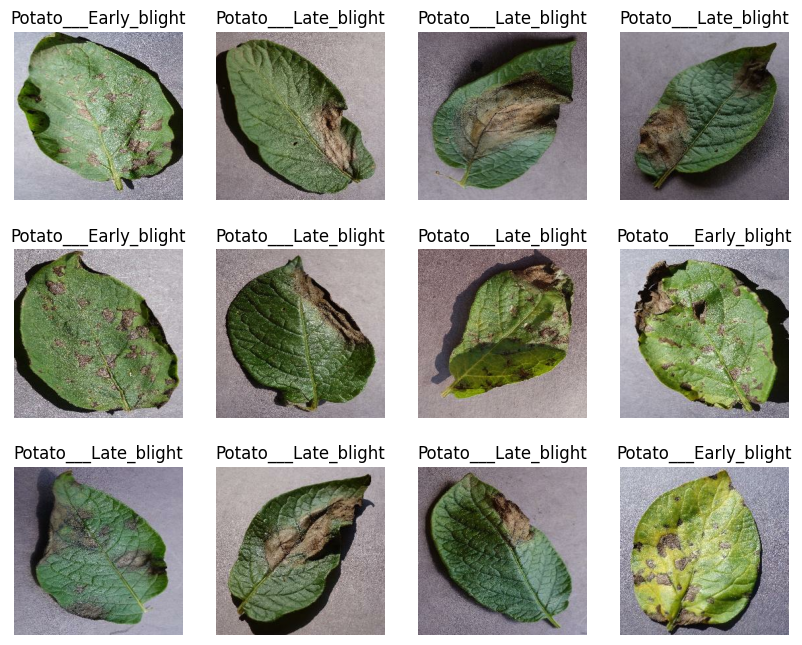

In [11]:
plt.figure(figsize=(10, 8))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)
    print(image_batch[0].shape)
    for i in range(12):
        ax= plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

splitting data :
80% => training
 
20% =>test and validate

In [12]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [3]:
test_ds =dataset.skip(54)
len(test_ds)

NameError: name 'dataset' is not defined

In [15]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds= test_ds.skip(6)
len(test_ds)

8

Partition Dataset

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split = 0.1, shuffle=True,shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

In [23]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/50
54/54 [==============================] - 37s 267ms/step - loss: 0.9207 - accuracy: 0.4734 - val_loss: 0.8770 - val_accuracy: 0.7240
Epoch 2/50
54/54 [==============================] - 13s 241ms/step - loss: 0.8154 - accuracy: 0.5938 - val_loss: 0.5913 - val_accuracy: 0.7500
Epoch 3/50
54/54 [==============================] - 13s 232ms/step - loss: 0.5763 - accuracy: 0.7703 - val_loss: 0.4383 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 12s 230ms/step - loss: 0.4063 - accuracy: 0.8356 - val_loss: 0.4114 - val_accuracy: 0.8177
Epoch 5/50
54/54 [==============================] - 12s 231ms/step - loss: 0.3126 - accuracy: 0.8773 - val_loss: 0.4538 - val_accuracy: 0.8073
Epoch 6/50
54/54 [==============================] - 13s 232ms/step - loss: 0.1926 - accuracy: 0.9306 - val_loss: 0.3340 - val_accuracy: 0.8490
Epoch 7/50
54/54 [==============================] - 12s 229ms/step - loss: 0.2332 - accuracy: 0.9144 - val_loss: 0.3071 - val_accuracy: 0.8802

In [31]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 1s 44ms/step - loss: 0.0387 - accuracy: 0.9844


In [33]:
scores

[0.03868628665804863, 0.984375]

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
history.history['accuracy']

[0.47337964177131653,
 0.59375,
 0.7702546119689941,
 0.8356481194496155,
 0.8773148059844971,
 0.9305555820465088,
 0.9143518805503845,
 0.9519675970077515,
 0.9461805820465088,
 0.9658564925193787,
 0.9704861044883728,
 0.9398148059844971,
 0.9618055820465088,
 0.9681712985038757,
 0.9641203880310059,
 0.9681712985038757,
 0.9745370149612427,
 0.9849537014961243,
 0.9797453880310059,
 0.9699074029922485,
 0.9774305820465088,
 0.9704861044883728,
 0.9814814925193787,
 0.9733796119689941,
 0.9861111044883728,
 0.984375,
 0.9890046119689941,
 0.9797453880310059,
 0.9820601940155029,
 0.9826388955116272,
 0.9884259104728699,
 0.9936342835426331,
 0.9849537014961243,
 0.9855324029922485,
 0.9866898059844971,
 0.9855324029922485,
 0.9907407164573669,
 0.9832175970077515,
 0.9855324029922485,
 0.9849537014961243,
 0.9930555820465088,
 0.9890046119689941,
 0.9947916865348816,
 0.9855324029922485,
 0.9936342835426331,
 0.9924768805503845,
 0.9930555820465088,
 0.9930555820465088,
 0.991898119

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

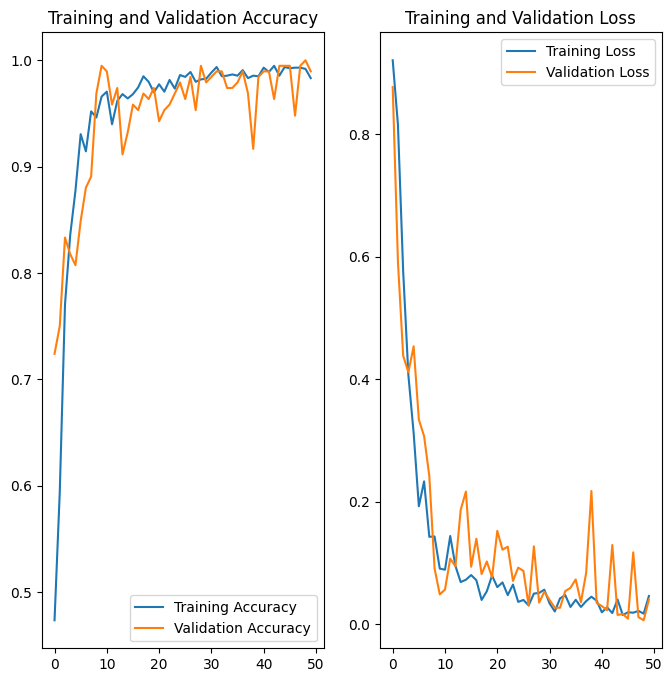

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [2]:
for images_batch, labels_batch in test_ds.take(1):
        first_image=images_batch[0].numpy().astype('uint8')
        first_label = labels_batch[0]

        print("first image to predict")
        plt.imshow(first_image)
        print("actual label:", class_names[first_label] )


        batch_prediction = model.predict(images_batch)
        print("predicted label:",class_names[np.argmax(batch_prediction[0])])

NameError: name 'test_ds' is not defined

In [78]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 *(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


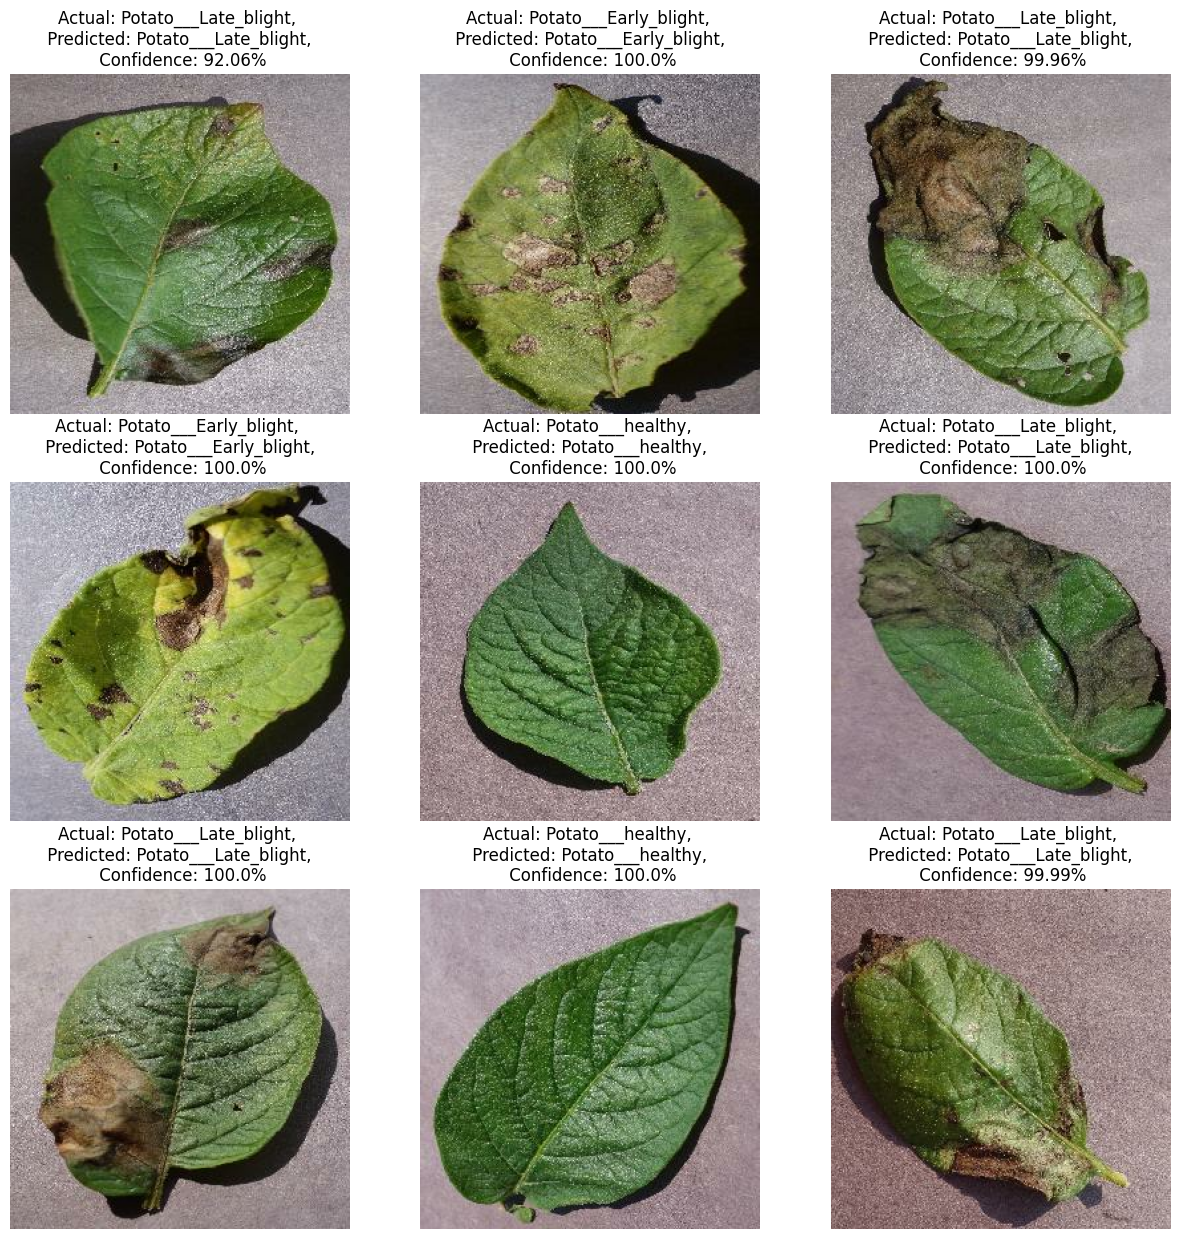

In [79]:
plt.figure(figsize = (15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis('off')

In [1]:
import os
model_version= max([int(i) for i in os.listdir("saved_models") +[0]])+1
model.save(f"saved_models/{model_version}")

NameError: name 'model' is not defined

Converting tf model from .pb to .h5

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

New_Model = tf.keras.models.load_model('saved_models/1/') # Loading the Tensorflow Saved Model (PB)
print(New_Model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [3]:
# Saving the Model in H5 Format and Loading it (to check if it is same as PB Format)
tf.keras.models.save_model(New_Model, 'New_Model.h5') # Saving the Model in H5 Format

loaded_model_from_h5 = tf.keras.models.load_model('New_Model.h5') # Loading the H5 Saved Model
print(loaded_model_from_h5.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  